# Setup

In [ ]:
!pip install gdown
!gdown 1AGybRCQ1OGp78whNoHhg0_R47gOoQ3md
!gdown 1czol6Vn1_7Is_12DYL62DkbmVO3Os2Rn

Downloading...
From: https://drive.google.com/uc?id=1AGybRCQ1OGp78whNoHhg0_R47gOoQ3md
To: /kaggle/working/tracks_metadata.csv
100%|██████████████████████████████████████| 3.61M/3.61M [00:00<00:00, 5.96MB/s]


# Prepare data

In [ ]:
import pandas as pd

metadata = pd.read_csv('/kaggle/working/tracks_metadata.csv')
metadata

,track_title,track_url,track_album,genre,track_id,preview_mp3,duration,artist_name,artist_url,release_date,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,...Baby One More Time,https://open.spotify.com/track/3MjUtNVVq3C8Fn0...,...Baby One More Time (Digital Deluxe Version),Pop,3MjUtNVVq3C8Fn0MP3zhXa,https://p.scdn.co/mp3-preview/174e01719c3b06ee...,3:31,Britney Spears,https://open.spotify.com/artist/26dSoYclwsYLMA...,1999-01-12T00:00:00Z,...,0.0,-5.745,0.0,0.0307,0.20200,0.000131,0.4430,0.9070,92.960,4.0
1,DJ Got Us Fallin' In Love (feat. Pitbull),https://open.spotify.com/track/4356Typ82hUiFAy...,Raymond v Raymond (Expanded Edition),Pop,4356Typ82hUiFAynbLYbPn,https://p.scdn.co/mp3-preview/1619c7342806281d...,3:40,USHER,https://open.spotify.com/artist/23zg3TcAtWQy7J...,2010-03-30T00:00:00Z,...,7.0,-3.398,0.0,0.1090,0.03380,0.000000,0.0820,0.6540,119.963,4.0
2,People,https://open.spotify.com/track/26b3oVLrRUaaybJ...,People,Pop,26b3oVLrRUaaybJulow9kz,https://p.scdn.co/mp3-preview/abcbc9adf10ae490...,3:4,Libianca,https://open.spotify.com/artist/7kjSuFGKhLm8b5...,2022-12-06T00:00:00Z,...,10.0,-7.621,0.0,0.0678,0.55100,0.000013,0.1020,0.6930,124.357,5.0
3,Somebody That I Used To Know,https://open.spotify.com/track/1qDrWA6lyx8cLEC...,Making Mirrors,Pop,1qDrWA6lyx8cLECdZE7TV7,https://p.scdn.co/mp3-preview/36e1e9984c1a58cb...,4:4,Gotye,https://open.spotify.com/artist/2AsusXITU8P25d...,2011-01-01T00:00:00Z,...,0.0,-6.932,1.0,0.0371,0.54800,0.000115,0.0989,0.7480,129.059,4.0
4,Murder On The Dancefloor,https://open.spotify.com/track/4tKGFmENO69tZR9...,Read My Lips,Pop,4tKGFmENO69tZR9ahgZu48,https://p.scdn.co/mp3-preview/340bdf7b29f2725f...,3:50,Sophie Ellis-Bextor,https://open.spotify.com/artist/2cBh5lVMg222FF...,2002-06-06T00:00:00Z,...,1.0,-5.281,0.0,0.0299,0.00234,0.000026,0.3120,0.8870,117.310,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,Concerto for Flute and String Orchestra: I. An...,https://open.spotify.com/track/1kfmtzWgmbZWcyA...,Concerto for Flute and String Orchestra: I. An...,classical,1kfmtzWgmbZWcyARriIyoc,https://p.scdn.co/mp3-preview/3661ee9f9648b2ec...,6:39,André Jolivet,https://open.spotify.com/artist/5RLjTTgn3q1gx0...,2024-05-03T00:00:00Z,...,4.0,-26.549,0.0,0.0444,0.97300,0.412000,0.0683,0.0819,135.197,4.0
8320,Wedding in the Carpathians (1938): Allegro viv...,https://open.spotify.com/track/7yGgY0UAHyeKTzV...,Piano Concerto/ Wedding in the carpathians,classical,7yGgY0UAHyeKTzVLAnPKKA,https://p.scdn.co/mp3-preview/108b39a48ddd6f4c...,1:20,Paul Constantinescu,https://open.spotify.com/artist/0DKEKOqm05e1gO...,2024-05-03T00:00:00Z,...,5.0,-28.691,1.0,0.0428,0.97600,0.273000,0.7050,0.1140,107.951,3.0
8321,"Sonata for Violin & Cello, M. 73: III. Lent",https://open.spotify.com/track/0wPblZFusgHJYrt...,"Sonata for Violin & Cello, M. 73: III. Lent",classical,0wPblZFusgHJYrt2rcEDHw,https://p.scdn.co/mp3-preview/fd98ee8e7d5d5520...,6:25,Maurice Ravel,https://open.spotify.com/artist/17hR0sYHpx7VYT...,2024-05-03T00:00:00Z,...,9.0,-21.796,0.0,0.0497,0.98600,0.884000,0.0706,0.0373,106.614,4.0
8322,"Partita No. 1 in B-Flat Major, BWV 825: I. Pre...",https://open.spotify.com/track/5QRPfmI6oWCXuKv...,Bach: Six Partitas,classical,5QRPfmI6oWCXuKvSZLvMBl,https://p.scdn.co/mp3-preview/639b5d212b7d4970...,2:8,Johann Sebastian Bach,https://open.spotify.com/artist/5aIqB5nVVvmFsv...,2024-05-03T00:00:00Z,...,9.0,-21.912,1.0,0.0402,0.78500,0.932000,0.2130,0.6980,179.638,4.0


In [ ]:
!unzip -q spectrogram.zip
!rm spectrogram.zip

In [ ]:
import os
len(os.listdir('spectrogram'))

8324

# Load data

In [ ]:
import os
import re
import numpy as np
import cv2
# from import_data import create_spectrogram
# from slice_spectrogram import slice_spect
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

"""
Converts images and labels into training and testing matrices.
"""
base_data_path = '/kaggle/working'
spectrogram_dir = 'spectrogram'
save_data_path = '/kaggle/working/Training_Data'
def load_dataset(verbose=1, mode=None, test_size=0.1):
    genre = {
        "pop": 0,
        "classical": 1,
        "jazz": 2,
        "hiphop": 3,
        "electronic":4,
        "rock":5,
        "country":6,
        "instrumental":7,
    }
    n_classes = len(genre)
    genre_new = {value: key for key, value in genre.items()}

    if os.path.exists(save_data_path):
        train_x = np.load(f"{save_data_path}/train_x.npy")
        train_y = np.load(f"{save_data_path}/train_y.npy")
        test_x = np.load(f"{save_data_path}/test_x.npy")
        test_y = np.load(f"{save_data_path}/test_y.npy")
        return train_x, train_y, test_x, test_y, n_classes, genre_new

    if(verbose > 0):
        print("Compiling Training and Testing Sets ...")

    filenames = []
    for f in os.listdir(os.path.join(base_data_path, spectrogram_dir)):
        if f.endswith(".jpg"):
            filenames.append(f)

    images_all = []
    labels_all = []
    for f in tqdm(filenames):
        genre_variable = f.split("_")[0]
        temp = cv2.imread(os.path.join(base_data_path, spectrogram_dir, f), cv2.IMREAD_UNCHANGED)
        if temp.shape[:2] == (128, 1280):
            images_all.append(cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY))
            labels_all.append(genre[genre_variable])

    images = np.array(images_all)
    labels = np.array(labels_all)
    labels = labels.reshape(labels.shape[0],1)
    train_x, test_x, train_y, test_y = train_test_split(images, labels, test_size=test_size, stratify=labels, random_state=42)

    # Convert the labels into one-hot vectors.
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y, num_classes=n_classes)

    os.makedirs(save_data_path, exist_ok=True)
    np.save("Training_Data/train_x.npy", train_x)
    np.save("Training_Data/train_y.npy", train_y)
    np.save("Training_Data/test_x.npy", test_x)
    np.save("Training_Data/test_y.npy", test_y)
    return train_x, train_y, test_x, test_y, n_classes, genre_new

train_x, train_y, test_x, test_y, n_classes, genre_new = load_dataset(verbose=1, test_size=0.2)

2024-05-10 07:50:34.679176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 07:50:34.679283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 07:50:34.807890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Compiling Training and Testing Sets ...


100%|██████████| 8324/8324 [00:22<00:00, 368.14it/s]


In [ ]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(6647, 128, 1280) (6647, 8)
(1662, 128, 1280) (1662, 8)


In [ ]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
target_names = [
        "pop",
        "classical",
        "jazz",
        "hiphop",
        "electronic",
        "rock",
        "country",
        "instrumental"
    ]

# CRNN

## Create model

In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras import initializers
from keras import optimizers
from keras.utils import plot_model
from keras.layers import *
# from load_data import load_dataset
import pandas as pd

model = Sequential()
model.add(Conv2D(filters=68, kernel_size=[3,3], padding='same', kernel_initializer = initializers.he_normal(seed=1), activation="relu", input_shape=(128,1280,1)))
# Dim = (122x122x64)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[2,2]))
# Dim = (61x61x64)
model.add(Conv2D(filters=137, kernel_size=[3,3], padding='same', kernel_initializer = initializers.he_normal(seed=1), activation="relu"))
# Dim = (28x28x128)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[3,3]))
# Dim = (14x14x128)
model.add(Conv2D(filters=137, kernel_size=[3,3], padding='same', kernel_initializer = initializers.he_normal(seed=1), activation="relu"))
# Dim = (12x12x256)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[4,4]))
# Dim = (6x6x256)
model.add(Conv2D(filters=137, kernel_size=[3,3], padding='same', kernel_initializer = initializers.he_normal(seed=1), activation="relu"))
# Dim = (4x4x512)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[4,4]))
# Dim = (2x2x512)
model.add(BatchNormalization())
model.add(Reshape((13,137)))
model.add(LSTM(units=64, return_sequences=True))
# Dim = (2048)
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(units=64))
# Dim = (1024)
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu", kernel_initializer=initializers.he_normal(seed=1)))
# Dim = (64)
model.add(Dense(32, activation="relu", kernel_initializer=initializers.he_normal(seed=1)))
# Dim = (32)
model.add(Dense(8, activation="softmax", kernel_initializer=initializers.he_normal(seed=1)))
Dim = (8)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 1280, 68)  │           680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 1280, 68)  │           272 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 64, 640, 68)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 640, 137)   │        83,981 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 640, 137)   │           548 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 21, 213, 137)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 213, 137)   │       169,058 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 213, 137)   │           548 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 5, 53, 137)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 53, 137)     │       169,058 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 53, 137)     │           548 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 1, 13, 137)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 13, 137)     │           548 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13, 137)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 13, 64)         │        51,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,16

 Total params: 516,737 (1.97 MB)

 Trainable params: 515,377 (1.97 MB)

 Non-trainable params: 1,360 (5.31 KB)

## Train model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True,
                               start_from_epoch=10)

# compile the model
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# fit the model
history = model.fit(train_x, train_y, epochs=50, verbose=1, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 101s 537ms/step - accuracy: 0.2852 - loss: 1.8482 - val_accuracy: 0.2503 - val_loss: 1.9501
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.6047 - loss: 1.2368 - val_accuracy: 0.5114 - val_loss: 1.3552
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.6387 - loss: 1.0367 - val_accuracy: 0.6709 - val_loss: 0.9100
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.6787 - loss: 0.9417 - val_accuracy: 0.7178 - val_loss: 0.8359
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.7119 - loss: 0.8615 - val_accuracy: 0.5668 - val_loss: 1.2854
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.7289 - loss: 0.7986 - val_accuracy: 0.7545 - val_loss: 0.7647
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.7283 - loss: 0.7818 - val_accuracy: 0.5915 - val_loss: 1.0456
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.7392 - loss: 

(0.0, 2.021605)

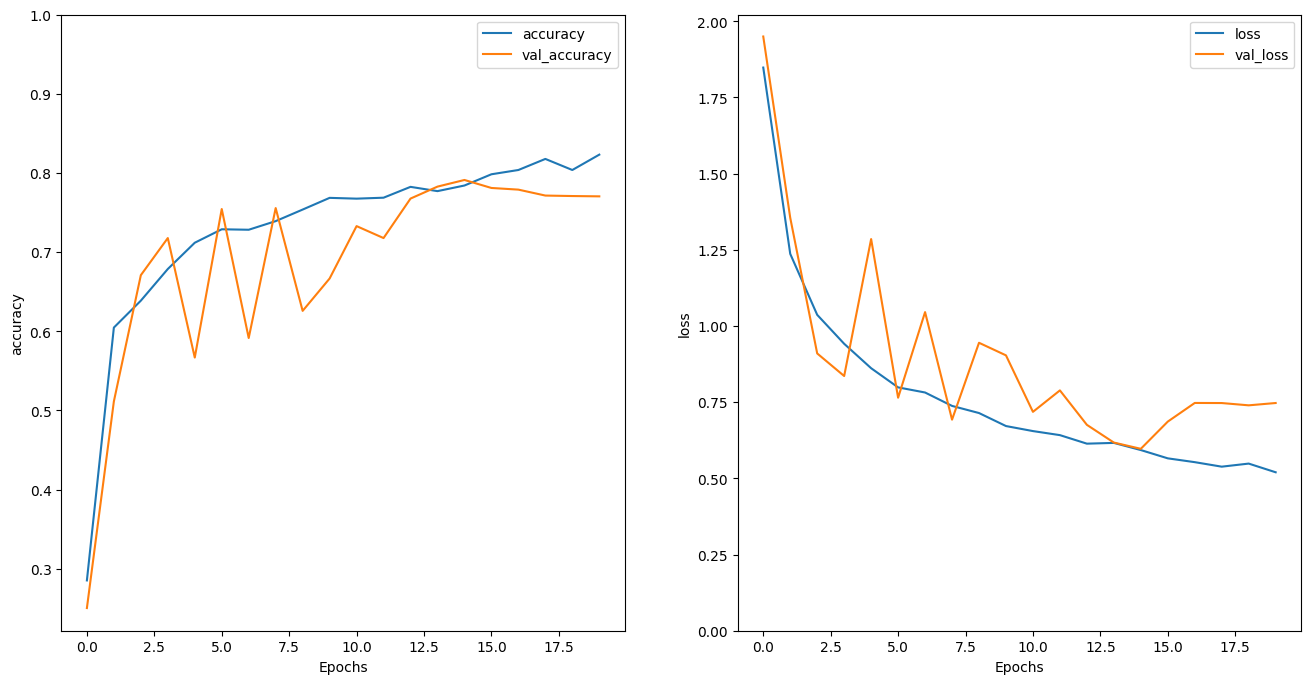

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric][:15])
    plt.plot(history.history['val_'+metric][:15])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## Evaluate model

In [ ]:
model.evaluate(test_x, test_y)

52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.7893 - loss: 0.5561


[0.5696791410446167, 0.7936221361160278]

52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step


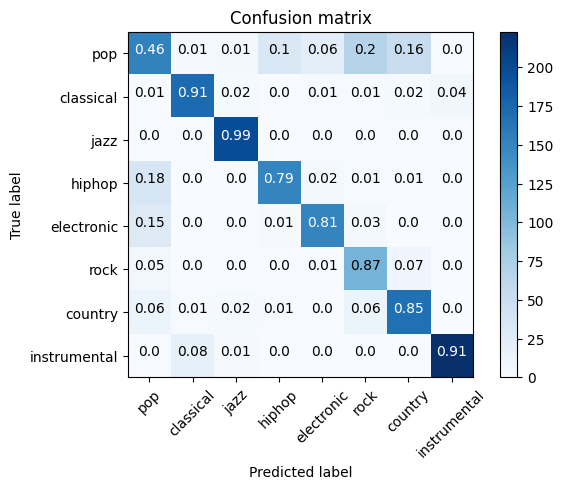

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_pred, np.argmax(test_y, axis=1))
plot_confusion_matrix(cm, target_names)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_y, axis=1), y_pred, target_names=target_names))

              precision    recall  f1-score   support

         pop       0.46      0.65      0.54       234
   classical       0.91      0.88      0.90       195
        jazz       0.99      0.94      0.96       211
      hiphop       0.79      0.81      0.80       186
  electronic       0.81      0.85      0.83       177
        rock       0.87      0.55      0.68       192
     country       0.85      0.71      0.78       236
instrumental       0.91      0.97      0.94       231

    accuracy                           0.79      1662
   macro avg       0.82      0.79      0.80      1662
weighted avg       0.82      0.79      0.80      1662



In [ ]:
model.save("/kaggle/working/saved_model_crnn_09_05_2024.h5")

## Inference model

In [ ]:
!gdown 100PeN-7XGqwtYHbzkSatI66xk9VFYNFO

Downloading...
From: https://drive.google.com/uc?id=100PeN-7XGqwtYHbzkSatI66xk9VFYNFO
To: /kaggle/working/saved_model_crnn.h5
100%|██████████████████████████████████████| 6.29M/6.29M [00:00<00:00, 9.33MB/s]


In [ ]:
from keras.models import Model, load_model

loaded_model = load_model("/kaggle/working/saved_model_crnn_09_05_2024.h5")

In [ ]:
from keras.models import Model

# Discard the classifycation layers
matrix_size = loaded_model.layers[-4].output.shape[1]
new_model = Model(loaded_model.inputs, loaded_model.layers[-4].output)
new_model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1280, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 1280, 68)  │           680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 1280, 68)  │           272 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 64, 640, 68)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 640, 137)   │        83,981 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 640, 137)   │           548 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 21, 213, 137)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 213, 137)   │       169,058 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 213, 137)   │           548 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 5, 53, 137)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 53, 137)     │       169,058 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 53, 137)     │           548 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 1, 13, 137)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 13, 137)     │           548 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13, 137)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 13, 64)         │        51,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             

 Total params: 510,233 (1.95 MB)

 Trainable params: 508,873 (1.94 MB)

 Non-trainable params: 1,360 (5.31 KB)

In [ ]:
matrix_size

64

In [ ]:
import os
from tqdm import tqdm
import cv2

base_data_path = '/kaggle/working'
spectrogram_dir = 'spectrogram'

filenames = []
for f in os.listdir(os.path.join(base_data_path, spectrogram_dir)):
    if f.endswith(".jpg"):
        filenames.append(f)

images = []
labels = []
for f in tqdm(filenames):
    genre_variable = f.split("_")[0]
    image = cv2.imread(os.path.join(base_data_path, spectrogram_dir, f), cv2.IMREAD_UNCHANGED)
    if image.shape[:2] == (128, 1280):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=0)
        images.append(image)
        labels.append(f.split("_")[1].split('.')[0])

images = np.concatenate(images)
embedd_images = new_model.predict(images)
labels = np.array(labels)

100%|██████████| 8324/8324 [00:19<00:00, 420.65it/s]


260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step


In [ ]:
print(embedd_images.shape)
np.save("/kaggle/working/embedd_images.npy", embedd_images)
np.save("/kaggle/working/labels.npy", labels)

(8309, 64)


In [ ]:
# Enter a song name which will be an anchor song.
# recommend_wrt = str(input("Enter Song name:\n"))
recommend_wrt = np.random.choice(labels)
song_name = metadata[metadata['track_id'] == recommend_wrt]['track_title'].iloc[0]
print("Input song name:", song_name)

Input song name: Quiet Storm


In [ ]:
%%time
prediction_anchor = np.zeros((1, matrix_size))
count = 0
predictions_song = []
predictions_label = []
counts = []
distance_array = []

# Calculate the latent feature vectors for all the songs.
for i in range(0, len(labels)):
    if(labels[i] == recommend_wrt):
        prediction = embedd_images[i]
        prediction_anchor = prediction_anchor + prediction
        count = count + 1
    elif(labels[i] not in predictions_label):
        predictions_label.append(labels[i])
        prediction = embedd_images[i]
        predictions_song.append(prediction)
        counts.append(1)
    elif(labels[i] in predictions_label):
        index = predictions_label.index(labels[i])
        prediction = embedd_images[i]
        predictions_song[index] = predictions_song[index] + prediction
        counts[index] = counts[index] + 1
# Count is used for averaging the latent feature vectors.
prediction_anchor = prediction_anchor / count
for i in range(len(predictions_song)):
    predictions_song[i] = predictions_song[i] / counts[i]
    # Cosine Similarity - Computes a similarity score of all songs with respect
    # to the anchor song.
    distance_array.append(np.sum(prediction_anchor * predictions_song[i]) / (np.sqrt(np.sum(prediction_anchor**2)) * np.sqrt(np.sum(predictions_song[i]**2))))

distance_array = np.array(distance_array)
recommendations = 0

print("Recommendation is:")

# Number of Recommendations is set to 5.
while recommendations < 5:
    index = np.argmax(distance_array)
    value = distance_array[index]
    song = metadata[metadata['track_id'] == predictions_label[index]]['track_title'].iloc[0]
    print("Song Name: " + song + " with value = %f" % (value))
    distance_array[index] = -np.inf
    recommendations = recommendations + 1

Recommendation is:
Song Name: Point Me 2 (with Cardi B) with value = 0.998084
Song Name: TOPIA TWINS (feat. Rob49 & 21 Savage) with value = 0.997863
Song Name: Stick Talk with value = 0.997778
Song Name: H.Y.B. (feat. Bas & Central Cee) with value = 0.997750
Song Name: Boogieman with value = 0.997207
CPU times: user 1.29 s, sys: 872 µs, total: 1.3 s
Wall time: 1.29 s


# NN

In [ ]:
metadata.columns[11:]

Index(['is_explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [ ]:
metadata['is_explicit'] = metadata['is_explicit'].astype('float64')

In [ ]:
# Get min and max of numeric columns only
numeric_cols = metadata.select_dtypes(include=['number']).columns
for col in numeric_cols:
    print('col:', col, 'min:', metadata[col].min(), ', max:', metadata[col].max(),
          ', n_unique:', metadata[col].nunique())

col: is_explicit min: 0.0 , max: 1.0 , n_unique: 2
col: danceability min: 0.0 , max: 0.979 , n_unique: 903
col: energy min: 0.000155 , max: 0.997 , n_unique: 1890
col: key min: 0.0 , max: 11.0 , n_unique: 12
col: loudness min: -50.06 , max: 1.002 , n_unique: 6716
col: mode min: 0.0 , max: 1.0 , n_unique: 2
col: speechiness min: 0.0 , max: 0.823 , n_unique: 1059
col: acousticness min: 1.36e-06 , max: 0.996 , n_unique: 2393
col: instrumentalness min: 0.0 , max: 0.986 , n_unique: 2562
col: liveness min: 0.0219 , max: 0.979 , n_unique: 1102
col: valence min: 0.0 , max: 0.986 , n_unique: 1353
col: tempo min: 0.0 , max: 219.169 , n_unique: 7486
col: time_signature min: 0.0 , max: 5.0 , n_unique: 5


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Apply Min-Max scaling to all columns
metadata_scaled = pd.DataFrame(scaler.fit_transform(metadata[numeric_cols]), columns=numeric_cols)
metadata_scaled

,is_explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.0,0.775281,0.701057,0.000000,0.867867,0.0,0.037303,0.202810,0.000133,0.439975,0.919878,0.424148,0.8
1,0.0,0.677222,0.863570,0.636364,0.913830,0.0,0.132442,0.033934,0.000000,0.062794,0.663286,0.547354,0.8
2,0.0,0.585291,0.423180,0.909091,0.831127,0.0,0.082382,0.553212,0.000013,0.083690,0.702840,0.567402,1.0
3,0.0,0.883555,0.522493,0.000000,0.844620,1.0,0.045079,0.550200,0.000117,0.080451,0.758621,0.588856,0.8
4,0.0,0.745659,0.851532,0.090909,0.876954,0.0,0.036330,0.002348,0.000026,0.303103,0.899594,0.535249,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,0.0,0.325843,0.041777,0.363636,0.460440,0.0,0.053949,0.976908,0.417850,0.048480,0.083063,0.616862,0.8
8320,0.0,0.382022,0.021011,0.454545,0.418491,1.0,0.052005,0.979920,0.276876,0.713719,0.115619,0.492547,0.6
8321,0.0,0.161389,0.047294,0.818182,0.553523,0.0,0.060389,0.989960,0.896552,0.050883,0.037830,0.486447,0.8
8322,0.0,0.345250,0.211512,0.818182,0.551251,1.0,0.048846,0.788152,0.945233,0.199666,0.707911,0.819632,0.8


In [ ]:
# Get min and max of numeric columns only
numeric_cols = metadata_scaled.select_dtypes(include=['number']).columns
for col in numeric_cols:
    print('col:', col, 'min:', metadata_scaled[col].min(), ', max:', metadata_scaled[col].max(),
          ', n_unique:', metadata_scaled[col].nunique())

col: is_explicit min: 0.0 , max: 1.0 , n_unique: 2
col: danceability min: 0.0 , max: 0.9999999999999999 , n_unique: 903
col: energy min: 0.0 , max: 1.0000000000000002 , n_unique: 1890
col: key min: 0.0 , max: 1.0 , n_unique: 12
col: loudness min: 0.0 , max: 0.9999999999999999 , n_unique: 6716
col: mode min: 0.0 , max: 1.0 , n_unique: 2
col: speechiness min: 0.0 , max: 1.0 , n_unique: 1059
col: acousticness min: 0.0 , max: 1.0 , n_unique: 2393
col: instrumentalness min: 0.0 , max: 1.0 , n_unique: 2562
col: liveness min: 0.0 , max: 1.0000000000000002 , n_unique: 1102
col: valence min: 0.0 , max: 1.0 , n_unique: 1353
col: tempo min: 0.0 , max: 1.0 , n_unique: 7486
col: time_signature min: 0.0 , max: 1.0 , n_unique: 5


In [ ]:
import numpy as np

# Genre mapping dictionary
genre_mapping = {
    "pop": 0,
    "classical": 1,
    "jazz": 2,
    "hiphop": 3,
    "electronic": 4,
    "rock": 5,
    "country": 6,
    "instrumental": 7,
}

X = metadata_scaled.values
y = metadata['genre'].values
y = np.array([genre_mapping[genre.lower()] for genre in y])
y = np.eye(len(genre_mapping))[y]
print(X.shape, y.shape)

(8324, 13) (8324, 8)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6659, 13) (6659, 8)
(1665, 13) (1665, 8)


In [ ]:
from tensorflow import keras

# Define the model
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(genre_mapping), activation='softmax')
])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,256 (176.78 KB)

 Trainable params: 45,256 (176.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2489 - loss: 2.0350 - val_accuracy: 0.4090 - val_loss: 1.7629
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4285 - loss: 1.6509 - val_accuracy: 0.4691 - val_loss: 1.3931
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4785 - loss: 1.3516 - val_accuracy: 0.5063 - val_loss: 1.2380
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5105 - loss: 1.2268 - val_accuracy: 0.5057 - val_loss: 1.1685
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5153 - loss: 1.1716 - val_accuracy: 0.5321 - val_loss: 1.1240
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5425 - loss: 1.1134 - val_accuracy: 0.5423 - val_loss: 1.0996
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5545 - loss: 1.0794 - val_accuracy: 0.5712 - val_loss: 1.0573
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5737 - loss: 1.0695 - val_accu

(0.0, 2.0140131443738936)

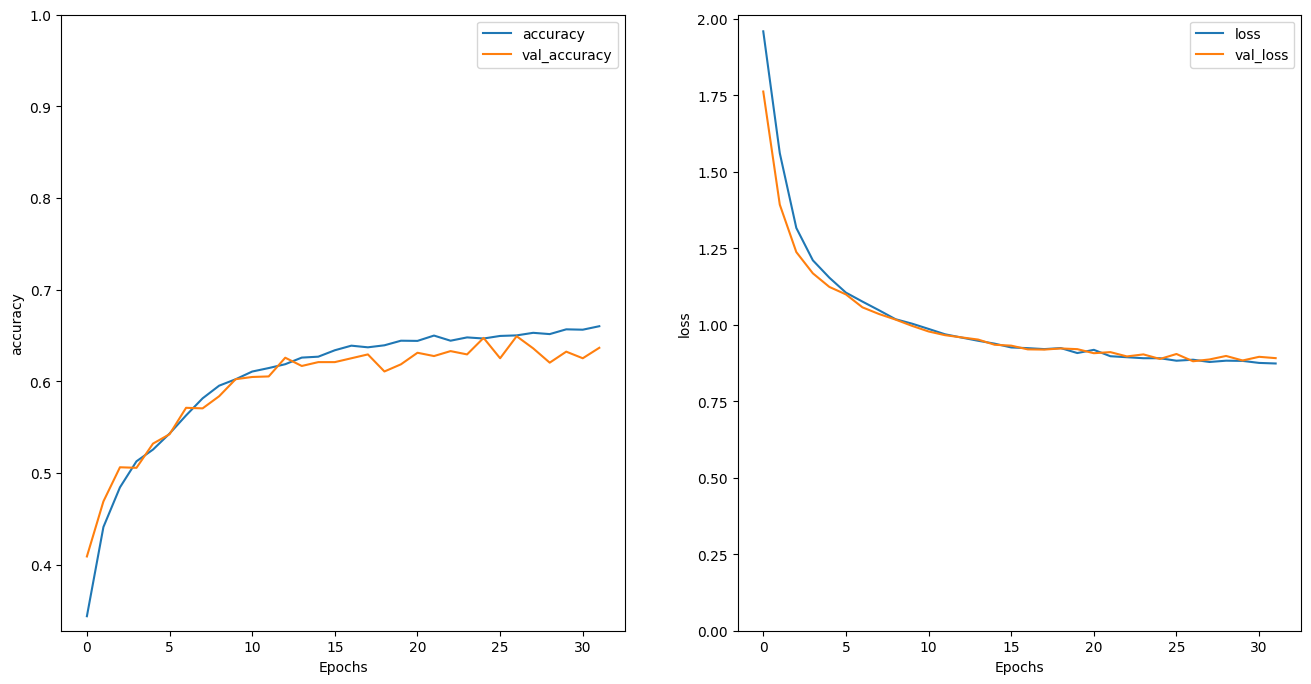

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6481 - loss: 0.9119
Test accuracy: 0.6486486196517944


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


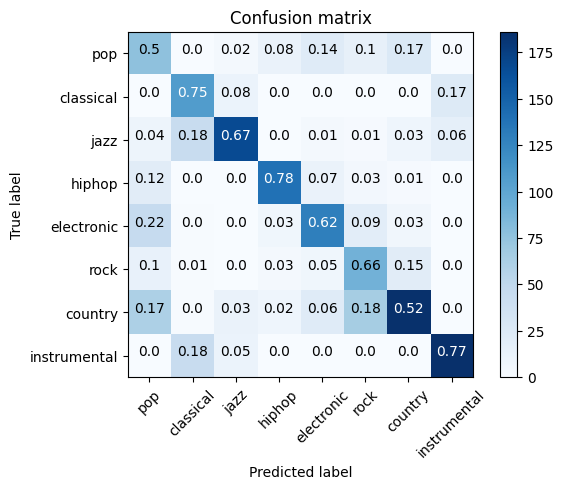

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_pred, np.argmax(y_test, axis=1))
plot_confusion_matrix(cm, target_names)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

              precision    recall  f1-score   support

         pop       0.50      0.34      0.40       228
   classical       0.75      0.54      0.63       198
        jazz       0.67      0.82      0.74       204
      hiphop       0.78      0.82      0.80       170
  electronic       0.62      0.66      0.64       195
        rock       0.66      0.46      0.54       196
     country       0.52      0.75      0.61       248
instrumental       0.77      0.82      0.80       226

    accuracy                           0.65      1665
   macro avg       0.66      0.65      0.64      1665
weighted avg       0.65      0.65      0.64      1665



In [ ]:
model.save("/kaggle/working/saved_model_mlp.h5")

In [ ]:
!gdown 1R7bmw1VLReWINqZ0fb28sVeiOP_ACp5v

Downloading...
From: https://drive.google.com/uc?id=1R7bmw1VLReWINqZ0fb28sVeiOP_ACp5v
To: /kaggle/working/saved_model_mlp.h5
100%|████████████████████████████████████████| 571k/571k [00:00<00:00, 1.62MB/s]


In [ ]:
from keras.models import Model, load_model

loaded_model = load_model("/kaggle/working/saved_model_mlp.h5")
loaded_model.evaluate(X_test, y_test)

new_model = Model(loaded_model.inputs, loaded_model.layers[-2].output)
new_model.summary()

2024-05-13 06:36:28.826316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 06:36:28.826422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 06:36:28.941556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


35/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6504 - loss: 0.9149 

I0000 00:00:1715582199.946359      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6481 - loss: 0.9119


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,736 (174.75 KB)

 Trainable params: 44,736 (174.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
metadata

,track_title,track_url,track_album,genre,track_id,preview_mp3,duration,artist_name,artist_url,release_date,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,...Baby One More Time,https://open.spotify.com/track/3MjUtNVVq3C8Fn0...,...Baby One More Time (Digital Deluxe Version),Pop,3MjUtNVVq3C8Fn0MP3zhXa,https://p.scdn.co/mp3-preview/174e01719c3b06ee...,3:31,Britney Spears,https://open.spotify.com/artist/26dSoYclwsYLMA...,1999-01-12T00:00:00Z,...,0.0,-5.745,0.0,0.0307,0.20200,0.000131,0.4430,0.9070,92.960,4.0
1,DJ Got Us Fallin' In Love (feat. Pitbull),https://open.spotify.com/track/4356Typ82hUiFAy...,Raymond v Raymond (Expanded Edition),Pop,4356Typ82hUiFAynbLYbPn,https://p.scdn.co/mp3-preview/1619c7342806281d...,3:40,USHER,https://open.spotify.com/artist/23zg3TcAtWQy7J...,2010-03-30T00:00:00Z,...,7.0,-3.398,0.0,0.1090,0.03380,0.000000,0.0820,0.6540,119.963,4.0
2,People,https://open.spotify.com/track/26b3oVLrRUaaybJ...,People,Pop,26b3oVLrRUaaybJulow9kz,https://p.scdn.co/mp3-preview/abcbc9adf10ae490...,3:4,Libianca,https://open.spotify.com/artist/7kjSuFGKhLm8b5...,2022-12-06T00:00:00Z,...,10.0,-7.621,0.0,0.0678,0.55100,0.000013,0.1020,0.6930,124.357,5.0
3,Somebody That I Used To Know,https://open.spotify.com/track/1qDrWA6lyx8cLEC...,Making Mirrors,Pop,1qDrWA6lyx8cLECdZE7TV7,https://p.scdn.co/mp3-preview/36e1e9984c1a58cb...,4:4,Gotye,https://open.spotify.com/artist/2AsusXITU8P25d...,2011-01-01T00:00:00Z,...,0.0,-6.932,1.0,0.0371,0.54800,0.000115,0.0989,0.7480,129.059,4.0
4,Murder On The Dancefloor,https://open.spotify.com/track/4tKGFmENO69tZR9...,Read My Lips,Pop,4tKGFmENO69tZR9ahgZu48,https://p.scdn.co/mp3-preview/340bdf7b29f2725f...,3:50,Sophie Ellis-Bextor,https://open.spotify.com/artist/2cBh5lVMg222FF...,2002-06-06T00:00:00Z,...,1.0,-5.281,0.0,0.0299,0.00234,0.000026,0.3120,0.8870,117.310,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,Concerto for Flute and String Orchestra: I. An...,https://open.spotify.com/track/1kfmtzWgmbZWcyA...,Concerto for Flute and String Orchestra: I. An...,classical,1kfmtzWgmbZWcyARriIyoc,https://p.scdn.co/mp3-preview/3661ee9f9648b2ec...,6:39,André Jolivet,https://open.spotify.com/artist/5RLjTTgn3q1gx0...,2024-05-03T00:00:00Z,...,4.0,-26.549,0.0,0.0444,0.97300,0.412000,0.0683,0.0819,135.197,4.0
8320,Wedding in the Carpathians (1938): Allegro viv...,https://open.spotify.com/track/7yGgY0UAHyeKTzV...,Piano Concerto/ Wedding in the carpathians,classical,7yGgY0UAHyeKTzVLAnPKKA,https://p.scdn.co/mp3-preview/108b39a48ddd6f4c...,1:20,Paul Constantinescu,https://open.spotify.com/artist/0DKEKOqm05e1gO...,2024-05-03T00:00:00Z,...,5.0,-28.691,1.0,0.0428,0.97600,0.273000,0.7050,0.1140,107.951,3.0
8321,"Sonata for Violin & Cello, M. 73: III. Lent",https://open.spotify.com/track/0wPblZFusgHJYrt...,"Sonata for Violin & Cello, M. 73: III. Lent",classical,0wPblZFusgHJYrt2rcEDHw,https://p.scdn.co/mp3-preview/fd98ee8e7d5d5520...,6:25,Maurice Ravel,https://open.spotify.com/artist/17hR0sYHpx7VYT...,2024-05-03T00:00:00Z,...,9.0,-21.796,0.0,0.0497,0.98600,0.884000,0.0706,0.0373,106.614,4.0
8322,"Partita No. 1 in B-Flat Major, BWV 825: I. Pre...",https://open.spotify.com/track/5QRPfmI6oWCXuKv...,Bach: Six Partitas,classical,5QRPfmI6oWCXuKvSZLvMBl,https://p.scdn.co/mp3-preview/639b5d212b7d4970...,2:8,Johann Sebastian Bach,https://open.spotify.com/artist/5aIqB5nVVvmFsv...,2024-05-03T00:00:00Z,...,9.0,-21.912,1.0,0.0402,0.78500,0.932000,0.2130,0.6980,179.638,4.0


In [ ]:
embedd_metadata = {}
tmp = new_model.predict(X)
for i in range(len(metadata)):
    embedd_metadata[metadata['track_id'][i]] = tmp[i].tolist()

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
import json
with open("embedd_metadata.json", "w") as f:
    json.dump(embedd_metadata, f)